Mount drive to access checkpoints and datasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Imports

In [ ]:
import os
import time
import os
import pandas as pd
import json
import numpy as np
from PIL import Image as pimg
import matplotlib.pyplot as plt
import random

# Constants

In [ ]:
annot = json.load(open('/content/drive/MyDrive/231A Final Project/InfiniteForm/clean_annotations.json','r'))

width, height = 640, 480

skeleton_inf = [[16,14],[14,12],[17,15],[15,13],[12,13],[6,12],[7,13],[6,7],[6,8],[7,9],[8,10],[9,11],[2,3],[1,2],[1,3],[2,4],[3,5],[4,6],[5,7]]
s = np.array(skeleton_inf).flatten()
s = s - 1
skeleton_inf = s.reshape(-1,2)

# Helpers

In [ ]:
def evaluate_inf_validation_accuracy(preds, gt):
    threshold = 0.5

    pos_gt_src = gt.reshape(1, 12, 2)
    waist_diams = np.linalg.norm(pos_gt_src[0,6,:] - pos_gt_src[0,7,:]).reshape(1, -1)
    preds = preds.reshape(1, 12, 2)
    preds = np.transpose(preds, [1, 2, 0])
    pos_gt_src = np.transpose(pos_gt_src, [1, 2, 0])

    uv_error = preds - pos_gt_src
    uv_err = np.linalg.norm(uv_error, axis=1)
    
    scale = np.multiply(waist_diams, np.ones((len(uv_err), 1)))
    scaled_uv_err = np.divide(uv_err, scale)
    jnt_count = 12 # CHANGE IF ANYTHING CHANGES
    less_than_threshold = (scaled_uv_err < threshold)
    return less_than_threshold

In [ ]:
def visualize_infinite_form_format(pred, gt, img_path):
  img = pimg.open(img_path)
  plt.figure(figsize=(16,12))
  plt.imshow(img)
  plt.axis('off')

  plt.scatter(pred[:,0], pred[:,1], color='blue', marker='.', label='Predictions')
  plt.scatter(gt[5:,0], gt[5:,1], color='orange', marker='.', label='Ground Truth')

  # GT lines
  for l in skeleton_inf:
    p1, p2 = l
    if p1 in [0,1,2,3,4] or p2 in [0,1,2,3,4]:
      continue
    x = [gt[p1,0],gt[p2,0]]
    y = [gt[p1,1],gt[p2,1]]
    plt.plot(x,y, color='orange')

  # Pred lines
  for l in skeleton_inf:
    p1, p2 = l
    if p1 in [0,1,2,3,4] or p2 in [0,1,2,3,4]:
      continue
    x = [pred[p1-5,0],pred[p2-5,0]]
    y = [pred[p1-5,1],pred[p2-5,1]]
    plt.plot(x,y, color='blue')

  plt.legend()
  plt.title(img_path.split('/')[-1])
  plt.show()

# Environment setup

In [ ]:
! git clone https://github.com/daniegr/EfficientPose.git
%cd EfficientPose
! pip install -r requirements.txt --quiet
! pip install pymediainfo==4.1 --quiet
! apt-get update -y
! apt-get install -y libmediainfo-dev

# Run on InfiniteForm
#### (InfiniteForm clean version, 2647 Images)

In [ ]:
path = '/content/drive/MyDrive/InfiniteForm/clean_dataset/'

# We set a limit to 250 because inference time is about 8 seconds

random.seed(5)
files_to_analyze = os.listdir(path)
random.shuffle(files_to_analyze)

i = 0
for filename in files_to_analyze:
  time.sleep(0.5)
  stream = os.popen("python track.py --model=IV --store --framework=pytorch --path=" + path + filename)
  print(stream.read())
  i += 1
  print('Image ' + str(i))
  if i == 250:
    break


Output PCK metrics

In [ ]:
path = "/content/drive/MyDrive/231A Final Project/InfiniteForm/efficientpose_predictions/random_250_images_lite/"

pcks = []
inf_form_filenames = []
save_file_list = False

for filename in os.listdir(path):
  f = pd.read_csv(path + filename)
  right_shoulder = [f['right_shoulder_x'][0]*width,f['right_shoulder_y'][0]*height]
  right_elbow = [f['right_elbow_x'][0]*width,f['right_elbow_y'][0]*height]
  right_wrist = [f['right_wrist_x'][0]*width,f['right_wrist_y'][0]*height]

  left_shoulder = [f['left_shoulder_x'][0]*width,f['left_shoulder_y'][0]*height]
  left_elbow = [f['left_elbow_x'][0]*width,f['left_elbow_y'][0]*height]
  left_wrist = [f['left_wrist_x'][0]*width,f['left_wrist_y'][0]*height]

  right_hip = [f['right_hip_x'][0]*width,f['right_hip_y'][0]*height]
  right_knee = [f['right_knee_x'][0]*width,f['right_knee_y'][0]*height]
  right_ankle= [f['right_ankle_x'][0]*width,f['right_ankle_y'][0]*height]

  left_hip = [f['left_hip_x'][0]*width,f['left_hip_y'][0]*height]
  left_knee = [f['left_knee_x'][0]*width,f['left_knee_y'][0]*height]
  left_ankle= [f['left_ankle_x'][0]*width,f['left_ankle_y'][0]*height]

  inf_joint_pred = np.asarray([left_shoulder, right_shoulder, left_elbow, right_elbow, left_wrist, \
                    right_wrist, left_hip, right_hip, left_knee, right_knee, left_ankle, right_ankle])

  ind = str(int(filename.split('_')[0]))
  gt = np.array(annot[ind]['keypoints']).reshape(17,-1)[:,:-1][5:]

  pcks.append(evaluate_inf_validation_accuracy(inf_joint_pred, gt))
  inf_form_filenames.append(ind)

if save_file_list:
  with open ('/content/drive/MyDrive/231A Final Project/InfiniteForm/efficientpose_predictions/250_inf_form.txt','w') as f:
    for fn in inf_form_filenames:
      f.write(fn + '\n')

In [ ]:
s, e, w, h, k, a = [], [], [], [], [], []
mm = []

for p in pcks:
  shoulder = p[[0,1]]
  elbow = p[[2,3]]
  wrist = p[[4,5]]
  hip = p[[6,7]]
  knee = p[[8,9]]
  ankle = p[[10,11]]

  s.append(shoulder)
  e.append(elbow)
  w.append(wrist)
  h.append(hip)
  k.append(knee)
  a.append(ankle)
  mm.append(np.mean(p))

s = np.round(np.mean(np.array(s).flatten()),2)
e = np.round(np.mean(np.array(e).flatten()),2)
w = np.round(np.mean(np.array(w).flatten()),2)
h = np.round(np.mean(np.array(h).flatten()),2)
k = np.round(np.mean(np.array(k).flatten()),2)
a = np.round(np.mean(np.array(a).flatten()),2)

m = np.round(np.mean([s,e,w,h,k,a]),2)

print('Max: ' + str(max(mm)) + '\n' + 'Filename: ' + inf_form_filenames[np.argmax(mm)] + '\n')

print('Final validation PCK scores:' + '\n')
print('Shoulder    Elbow    Wrist    Hip    Knee    Ankle    Mean')
print('--------    -----    -----    ---    ----    -----    ----')
print('  ' + str(s) + '       ' + str(e) + '     ' + str(w) + '    ' + str(h) + \
      '    ' + str(k) + '     ' + str(a) + '     ' + str(m))

Visualize sample prediction

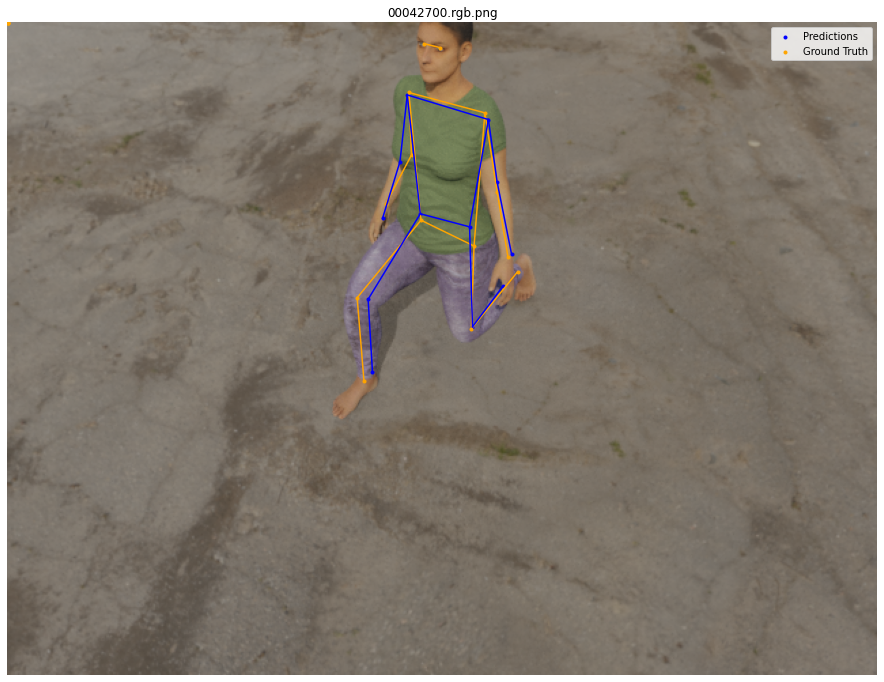

In [ ]:
filename = '00042700_coordinates.csv'
f = pd.read_csv(path + filename)
right_shoulder = [f['right_shoulder_x'][0]*width,f['right_shoulder_y'][0]*height]
right_elbow = [f['right_elbow_x'][0]*width,f['right_elbow_y'][0]*height]
right_wrist = [f['right_wrist_x'][0]*width,f['right_wrist_y'][0]*height]

left_shoulder = [f['left_shoulder_x'][0]*width,f['left_shoulder_y'][0]*height]
left_elbow = [f['left_elbow_x'][0]*width,f['left_elbow_y'][0]*height]
left_wrist = [f['left_wrist_x'][0]*width,f['left_wrist_y'][0]*height]

right_hip = [f['right_hip_x'][0]*width,f['right_hip_y'][0]*height]
right_knee = [f['right_knee_x'][0]*width,f['right_knee_y'][0]*height]
right_ankle= [f['right_ankle_x'][0]*width,f['right_ankle_y'][0]*height]

left_hip = [f['left_hip_x'][0]*width,f['left_hip_y'][0]*height]
left_knee = [f['left_knee_x'][0]*width,f['left_knee_y'][0]*height]
left_ankle= [f['left_ankle_x'][0]*width,f['left_ankle_y'][0]*height]

inf_joint_pred = np.asarray([left_shoulder, right_shoulder, left_elbow, right_elbow, left_wrist, \
                  right_wrist, left_hip, right_hip, left_knee, right_knee, left_ankle, right_ankle])

ind = str(int(filename.split('_')[0]))
gt = np.array(annot[ind]['keypoints']).reshape(17,-1)[:,:-1]

visualize_infinite_form_format(inf_joint_pred, gt, '/content/drive/MyDrive/231A Final Project/InfiniteForm/clean_dataset/' + \
                                filename.split('_')[0] + '.rgb.png')

# Person size analysis

In [ ]:
random250_path = "/content/drive/MyDrive/231A Final Project/InfiniteForm/efficientpose_predictions/random_250_images/"

In [ ]:
pcks = []
inf_form_filenames = []
save_file_list = False

for filename in os.listdir(random250_path):
  f = pd.read_csv(random250_path + filename)
  right_shoulder = [f['right_shoulder_x'][0]*width,f['right_shoulder_y'][0]*height]
  right_elbow = [f['right_elbow_x'][0]*width,f['right_elbow_y'][0]*height]
  right_wrist = [f['right_wrist_x'][0]*width,f['right_wrist_y'][0]*height]

  left_shoulder = [f['left_shoulder_x'][0]*width,f['left_shoulder_y'][0]*height]
  left_elbow = [f['left_elbow_x'][0]*width,f['left_elbow_y'][0]*height]
  left_wrist = [f['left_wrist_x'][0]*width,f['left_wrist_y'][0]*height]

  right_hip = [f['right_hip_x'][0]*width,f['right_hip_y'][0]*height]
  right_knee = [f['right_knee_x'][0]*width,f['right_knee_y'][0]*height]
  right_ankle= [f['right_ankle_x'][0]*width,f['right_ankle_y'][0]*height]

  left_hip = [f['left_hip_x'][0]*width,f['left_hip_y'][0]*height]
  left_knee = [f['left_knee_x'][0]*width,f['left_knee_y'][0]*height]
  left_ankle= [f['left_ankle_x'][0]*width,f['left_ankle_y'][0]*height]

  inf_joint_pred = np.asarray([left_shoulder, right_shoulder, left_elbow, right_elbow, left_wrist, \
                    right_wrist, left_hip, right_hip, left_knee, right_knee, left_ankle, right_ankle])

  ind = str(int(filename.split('_')[0]))
  gt = np.array(annot[ind]['keypoints']).reshape(17,-1)[:,:-1][5:]

  pcks.append(evaluate_inf_validation_accuracy(inf_joint_pred, gt))
  inf_form_filenames.append(ind)

In [ ]:
prop_scores = {"0.05_to_0.075": [], "0.075_to_0.10": [], "0.1_and_up": []}
WIDTH=640
HEIGHT=480

for img_idx, img_name in enumerate(os.listdir(random250_path)):
  person_area = annot[str(int(img_name.split("_")[0]))]['area']
  img_area = WIDTH * HEIGHT
  proportion = person_area / img_area

  if proportion < 0.075:
    key = "0.05_to_0.075"
  elif proportion < 0.10:
    key = "0.075_to_0.10"
  else:
    key = "0.1_and_up"
  prop_scores[key].append(np.mean(pcks[img_idx]))

In [ ]:
for k,v in prop_scores.items():
  print(k, len(v), np.mean(v))